# Amazon Food Review: Making predictions over Amazon recommendation dateset

## Predictions
The purpose of this analysis is to build a prediction model for checking if the review is positive or negative. In this analysis, we will not focus on the score, but only positive/negative sentiment of the recommencdation.

The dataset is from Amazon's recommendation dataset of kaggle, we will build a Term-doc incidence matrix using term frequency and inverse document frequency ponderation.

# Part 1: Data Exploration

In [1]:
import numpy as np
import pandas as pd
import nltk

import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load data into dataframe
my_df = pd.read_csv('/content/Reviews.csv', sep = ",")

In [3]:
my_df.head(15)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


## Part 1.1: Understand the Raw Dataset

In [4]:
# data shape
my_df.shape

(568454, 10)

In [5]:
# Check the general information of the dataframe
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
# check the missing values
my_df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [7]:
# The summary will be used to predict, therefore only the observations with missing summary will be deleted
my_df.dropna(subset=["Summary"], inplace=True)

In [8]:
my_df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

Add the **Sentiment** column that turns the numeric score into 1 (positive) or 0 (negative)

In [9]:
# based on the distinct elements in "score", create a "Sentiment" column:
# if the score > 3 --> assume sentiment is positive --> use 1
# otherwise --> assume sentiment is negative --> use 0
my_df["Sentiment"] = my_df["Score"].apply(lambda x: 1 if x > 3 else 0)
my_df.head()

# df["Sentiment"] = df["Score"].apply(lambda score: "positive" if score > 3 else "negative")

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


In [10]:
# check the counts of positive and negative
print(my_df['Sentiment'].value_counts())

1    443777
0    124650
Name: Sentiment, dtype: int64


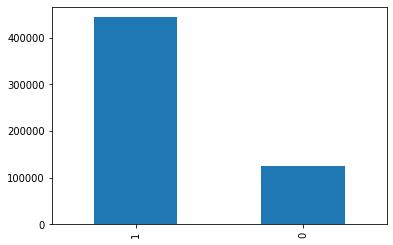

In [11]:
# plot bar chart to see the frequency of positive versus negative
my_df["Sentiment"].value_counts().plot.bar()

In [12]:
# check the propotion of target variable = 1
print(my_df["Sentiment"].sum() / my_df["Sentiment"].shape[0] * 100) 

78.07106277499133


In [13]:
# select the features that will be used in the later analysis
df_new = my_df.loc[:, ["Score", "Sentiment", "Summary", "Text"]]
df_new.head()

,Score,Sentiment,Summary,Text
0,5,1,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,1,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,0,Cough Medicine,If you are looking for the secret ingredient i...
4,5,1,Great taffy,Great taffy at a great price. There was a wid...


In [14]:
# Let's have a look at score 5
df_new[df_new.Score == 5].head(10)

,Score,Sentiment,Summary,Text
0,5,1,Good Quality Dog Food,I have bought several of the Vitality canned d...
4,5,1,Great taffy,Great taffy at a great price. There was a wid...
6,5,1,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,5,1,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,5,1,Yay Barley,Right now I'm mostly just sprouting this so my...
9,5,1,Healthy Dog Food,This is a very healthy dog food. Good for thei...
10,5,1,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
11,5,1,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...
14,5,1,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...
15,5,1,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...


In [15]:
# Let's have a look at score 1
df_new[df_new.Score == 1].head(10)

,Score,Sentiment,Summary,Text
1,1,0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
12,1,0,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...
26,1,0,Nasty No flavor,"The candy is just red , No flavor . Just plan..."
50,1,0,Don't like it,"This oatmeal is not good. Its mushy, soft, I d..."
62,1,0,stale product.,Arrived in 6 days and were so stale i could no...
73,1,0,Warning! WARNING! -ALCOHOL SUGARS!,Buyer Beware Please! This sweetener is not for...
75,1,0,No Tea Flavor,No tea flavor at all. Just whole brunch of art...
99,1,0,Bad,I fed this to my Golden Retriever and he hated...
153,1,0,Rip off Price,These singles sell for $2.50 - $3.36 at the st...
164,1,0,Tasteless but low calorie,Seriously this product was as tasteless as the...


# Part 2: Cleaning the data

stop words removal, stemming, Punctuations, lowering

## Part 2.1: Stopwords
* A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

![alt text](https://www.geeksforgeeks.org/wp-content/uploads/Stop-word-removal-using-NLTK.png)

In [16]:
from nltk.corpus import stopwords
stopwords = stopwords.words("english")
stopwords.append("'s")
stopwords.append("'m")
stopwords.append("n't")
stopwords.append("br")
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [17]:
"not" in stopwords

True

In [18]:
# we need to remove negative words from the stop words, such as "not", "no", "isn't", "can't", "couldn't", "don't", "wouldn't", "won't"
negtive_words = ["not", "no", "isn't", "can't", "couldn't", "don't", "wouldn't", "won't"]

for word in negtive_words:
  if word in stopwords:
    stopwords.remove(word)

print("We use " + str(len(stopwords)) + " stop-wrods from nltk library.")

We use 176 stop-wrods from nltk library.


##Part 2.2: stemming

In [19]:
from nltk.stem import SnowballStemmer # Stemmers remove morphological affixes from words, leaving only the word stem.
snow = SnowballStemmer('english') 
print(snow.stem('tasty'))
print(snow.stem('joined'))
print(snow.stem('apples'))

tasti
join
appl


##Part 2.3: Punctuations Removal

In [20]:
import re
# cleaning punctuations from the sentence
sentence = "I'd like to have some coffee today!"
sentence = re.sub(r'[\'|"|#]', r'', sentence) # remove these punctuation
sentence = re.sub(r'[?|!|.|,|)|(|\|/]',r' ',sentence) # replace these punctuation with space
sentence

'Id like to have some coffee today '

In [21]:
# Combine all the methods together as one function
def df_clean(text):
  text = str(text)
  text = text.lower() # lower case
  text = re.sub(r'[?|!|.|,|)|(|\|/]',r' ',text) # replace these punctuation with space
  words = text.split()

  res = []
  for word in words:
    if word not in stopwords:
      res.append(snow.stem(word))
  res = " ".join(res)
  res = re.sub(r'[\'|"|#]', r'', res) # remove these punctuation
  return res

In [22]:
# several examples
print(df_clean("how are you today?"))
print(df_clean("Not as Advertised"))
print(df_clean(6))

today
not advertis
6


In [23]:
# apply df_clean function to the "summary" column
df_new["Summary_Clean"] = df_new["Summary"].apply(df_clean)

In [24]:
df_new.head(10)

,Score,Sentiment,Summary,Text,Summary_Clean
0,5,1,Good Quality Dog Food,I have bought several of the Vitality canned d...,good qualiti dog food
1,1,0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,not advertis
2,4,1,"""Delight"" says it all",This is a confection that has been around a fe...,delight say
3,2,0,Cough Medicine,If you are looking for the secret ingredient i...,cough medicin
4,5,1,Great taffy,Great taffy at a great price. There was a wid...,great taffi
5,4,1,Nice Taffy,I got a wild hair for taffy and ordered this f...,nice taffi
6,5,1,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,great good expens brand
7,5,1,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,wonder tasti taffi
8,5,1,Yay Barley,Right now I'm mostly just sprouting this so my...,yay barley
9,5,1,Healthy Dog Food,This is a very healthy dog food. Good for thei...,healthi dog food


## Part 2.4: Visualize frequently used words in Summary for Sentiment with WordClouds

In [25]:
from wordcloud import WordCloud, ImageColorGenerator

In [26]:
# Extract only Summary_clean of reviews
heading_1 = df_new[df_new["Sentiment"]==1]["Summary_Clean"]
collapsed_heading_1 = heading_1.str.cat(sep=' ')

heading_2 = df_new[df_new["Sentiment"]==0]["Summary_Clean"]
collapsed_heading_2 = heading_2.str.cat(sep=' ')

Word Cloud for Positive


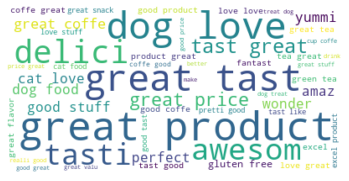


Word Cloud for Negative


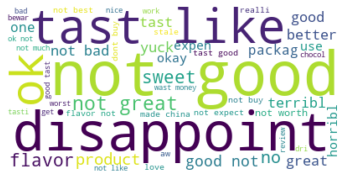

In [27]:
print("Word Cloud for Positive")

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_words=50).generate(collapsed_heading_1)

# Display the generated image:
# the matplotlib way:1
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("\nWord Cloud for Negative")

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_words=50).generate(collapsed_heading_2)

# Display the generated image:
# the matplotlib way:1
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Part 3: Train test split and TFIDF

In [28]:
# train test split before TFIDF for preventing data leakage
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_new, test_size=0.2, random_state = 1)
print("%d items in training data, %d in test data" % (len(train), len(test)))

454741 items in training data, 113686 in test data


In [29]:
# reset index
train = train.reset_index(drop=True)
train.head()

,Score,Sentiment,Summary,Text,Summary_Clean
0,5,1,Nutty and Intense,First impressions of this coffee was not posit...,nutti intens
1,1,0,Bad Candy,I ordered two of these items and gave them to ...,bad candi
2,5,1,Great popcorn,This is great popcorn! No extras needed. Just...,great popcorn
3,1,0,"made in the USA and made in Thailand, do they ...","I have two cats that are very picky eaters, so...",made usa made thailand hold qualiti
4,5,1,New Windsor Air Tight Bag,"Great flavor, fresh from the first tea bag to ...",new windsor air tight bag


In [30]:
test = test.reset_index(drop=True)
test.head()

,Score,Sentiment,Summary,Text,Summary_Clean
0,4,1,Surprisingly delicious,I was slightly suspicious when I purchased thi...,surpris delici
1,1,0,Ick- don't buy from amazon,I read some of the other reviews that warned t...,ick- dont buy amazon
2,5,1,Great Anchovies,These anchovies are of great quality. They ar...,great anchovi
3,5,1,Seriously Good Diabetic Friendly Bar - Highly ...,"The Extend ""Chocolate Delight"" bars are probab...",serious good diabet friend bar - high recommend
4,3,0,GOO FOOD,The wrappers are GOOD but it would have been e...,goo food


**TF-IDF Methods to convert text to vector**

* TF-IDF is an information retrieval technique that weighs a term's frequency (TF) and its inverse document frequency (IDF). Each word or term has its respective TF and IDF score. The product of the TF and IDF scores of a term is called the TF-IDF weight of that term

![alt text](https://1.bp.blogspot.com/-tnzPA6dDtTU/Vw6EWm_PjCI/AAAAAAABDwI/JatHtUJb4fsce9E-Ns5t02_nakFtGrsugCLcB/s1600/%25E8%259E%25A2%25E5%25B9%2595%25E5%25BF%25AB%25E7%2585%25A7%2B2016-04-14%2B%25E4%25B8%258A%25E5%258D%25881.39.07.png)



In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
train["Summary_Clean"].values

array(['nutti intens', 'bad candi', 'great popcorn', ...,
       'awesom malti scent', 'amazing- fri', 'excel buy hook'],
      dtype=object)

In [33]:
# define vectorizer parameters
# TfidfVectorizer from sklearn will create tf-idf matrix
# mim_df : maximum document frequency for the given word
# use_idf: if not true, we only calculate tf
# ngram_range: (min_value, max_value), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram
tfidf = TfidfVectorizer(ngram_range=(1,3)
                        , max_df = 0.99
                        , min_df = 5
                        , use_idf=True)
tfidf_vectors_train = tfidf.fit_transform(train["Summary_Clean"].values)
tfidf_vectors_test = tfidf.transform(test["Summary_Clean"].values)

In [34]:
tfidf_vectors_train.shape

(454741, 55314)

In [35]:
features = tfidf.get_feature_names_out()
features

array(['00', '00 per', '000', ..., 'zuke product', 'zuke treat',
       'zwieback'], dtype=object)

# Part 4: Model Training and Results Evaluation

In [36]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

# Logistic Regression
classifier_logistic = LogisticRegression()

# Random Forest
classifier_RF = RandomForestClassifier()

## Part 4.1: Logistic Regression

### Part 4.1.1: Check the performance of logistic regression by default

In [37]:
# Use 5-fold Cross Validation to check the accuracy of default logistic regression
X_train = tfidf_vectors_train
y_train = train["Sentiment"]

cv_score = model_selection.cross_val_score(classifier_logistic, X_train, y_train, cv=5)
print(cv_score)
print('Model accuracy of ' + "Logistic Regression" + ' is ' + str(cv_score.mean()))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[0.91020242 0.90831024 0.90803536 0.90789242 0.90867309]
Model accuracy of Logistic Regression is 0.9086227070360622


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### Part 4.1.2: Use grid search to find optimal hyperparameters for logistic regression

In [38]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

In [39]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

# ('l1', 1) ('l1', 5) ('l1', 10) ('l2', 1) ('l2', 5) ('l2', 10)
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(0.01, 0.05, 0.1, 0.5, 1, 5, 10) 
}
Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear'),parameters, cv=5)
Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': (0.01, 0.05, 0.1, 0.5, 1, 5, 10),
                         'penalty': ('l1', 'l2')})

In [40]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.9141027510790206
Best parameters set:
C:5
penalty:l2


In [41]:
# best model
best_LR_model = Grid_LR.best_estimator_

### Part 4.1.3: Model Evaluation - Confusion Matrix and AUC

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [43]:
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print (classifier)
    print ("Accuracy is: " + str(accuracy))
    print ("precision is: " + str(precision))
    print ("recall is: " + str(recall))

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Negative','Positive']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for ' + classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

Logistic Regression
Accuracy is: 0.9140175571310452
precision is: 0.9269541546039839
recall is: 0.9660786057665245


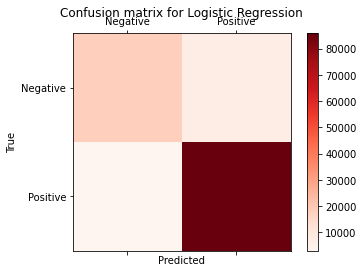

In [44]:
# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [ 
    ("Logistic Regression", confusion_matrix(test["Sentiment"],best_LR_model.predict(tfidf_vectors_test)))
]

draw_confusion_matrices(confusion_matrices)

In [45]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(tfidf_vectors_test)[:, 1]
fpr_lr, tpr_lr, thres = roc_curve(test["Sentiment"], y_pred_lr)

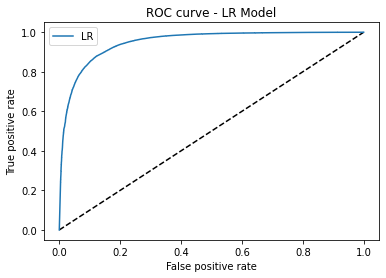

In [46]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [47]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.9491154018646322

## Part 4.2: Random Forest

In [48]:
tfidf_vectors_train.shape

(454741, 55314)

the features are 55490 which took me over 2 days to get the result, I remodified the tfidf_vectors_train for the random forest here

In [49]:
# define vectorizer parameters and only consider the previous 100 features, or the model training will take several days
tfidf_rf = TfidfVectorizer(ngram_range=(1,3)
                        , min_df=5
                        , max_features=100
                        , use_idf=True)
tfidf_vectors_train_rf = tfidf_rf.fit_transform(train["Summary_Clean"].values)
tfidf_vectors_test_rf = tfidf_rf.transform(test["Summary_Clean"].values)

In [50]:
tfidf_vectors_train_rf.shape

(454741, 100)

In [51]:
features = tfidf_rf.get_feature_names_out()
features

array(['addict', 'amaz', 'amazon', 'awesom', 'babi', 'bad', 'bar', 'best',
       'better', 'buy', 'candi', 'cat', 'cat love', 'cereal', 'chip',
       'chocol', 'coffe', 'cooki', 'cup', 'deal', 'delici', 'disappoint',
       'dog', 'dog food', 'dog love', 'dont', 'drink', 'easi', 'eat',
       'ever', 'excel', 'fantast', 'favorit', 'flavor', 'food', 'free',
       'fresh', 'get', 'gluten', 'gluten free', 'go', 'good',
       'good stuff', 'great', 'great coffe', 'great price',
       'great product', 'great tast', 'green', 'happi', 'healthi', 'high',
       'hot', 'like', 'littl', 'love', 'low', 'made', 'make', 'mix',
       'much', 'natur', 'nice', 'no', 'not', 'not good', 'oil', 'ok',
       'one', 'organ', 'packag', 'perfect', 'pretti', 'price', 'product',
       'qualiti', 'realli', 'review', 'salt', 'sauc', 'snack', 'strong',
       'stuff', 'sugar', 'sweet', 'tast', 'tast great', 'tast like',
       'tasti', 'tea', 'treat', 'tri', 'use', 'valu', 'water', 'way',
       'wonder', 

In [52]:
cv_score_rf = model_selection.cross_val_score(classifier_RF, tfidf_vectors_train_rf, y_train, cv=5)
print(cv_score_rf)
print('Model accuracy of ' + 'Random Forest' + ' is ' + str(cv_score_rf.mean()))

[0.83333517 0.83280556 0.83332234 0.83080442 0.83335532]
Model accuracy of Random Forest is 0.8327245605507194


In [53]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [60,80,100]
    , "max_depth" : np.arange(3, 11, 2)
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(tfidf_vectors_train_rf, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([3, 5, 7, 9]),
                         'n_estimators': [60, 80, 100]})

In [54]:
# the best hyperparameter combination
Grid_RF.best_params_

{'max_depth': 9, 'n_estimators': 80}

In [55]:
# best score
Grid_RF.best_score_

0.8163064258767181

In [56]:
# best random forest
best_RF_model = Grid_RF.best_estimator_

Random Forest
Accuracy is: 0.8154126277641927
precision is: 0.8145366197444315
recall is: 0.9889105299303108


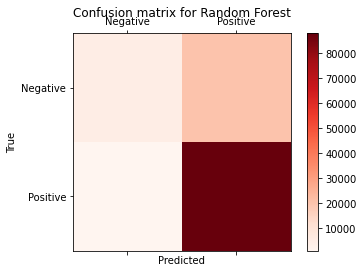

In [57]:
confusion_matrices = [
    ("Random Forest", confusion_matrix(test["Sentiment"],best_RF_model.predict(tfidf_vectors_test_rf)))
]
draw_confusion_matrices(confusion_matrices)

In [58]:
# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_RF_model.predict_proba(tfidf_vectors_test_rf)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(test["Sentiment"], y_pred_rf)

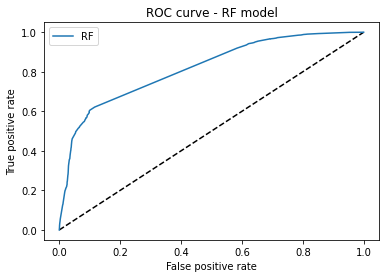

In [59]:
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [60]:
# AUC score
metrics.auc(fpr_rf,tpr_rf)

0.8174218510826174